# Datenbeschaffung und -reinigung

In [2]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.models import Sequential, load_model
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [3]:
dataset_path = 'Rice_Image_Dataset'

# Initialize empty lists for storing the images and labels
images = []
labels = []

In [4]:

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    
    # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

# Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

# Display the first few rows of the DataFrame
print(df.head())

                                            image    label
0      Rice_Image_Dataset\Arborio\Arborio (1).jpg  Arborio
1     Rice_Image_Dataset\Arborio\Arborio (10).jpg  Arborio
2    Rice_Image_Dataset\Arborio\Arborio (100).jpg  Arborio
3   Rice_Image_Dataset\Arborio\Arborio (1000).jpg  Arborio
4  Rice_Image_Dataset\Arborio\Arborio (10000).jpg  Arborio


# Explorative Datenanalyse (EDA)

## Analyse der Datenstrukturen

In [5]:
# Basic statistics about the dataset
print(df['label'].value_counts())

label
Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
Name: count, dtype: int64


## Erkennung von Mustern und Beziehungen

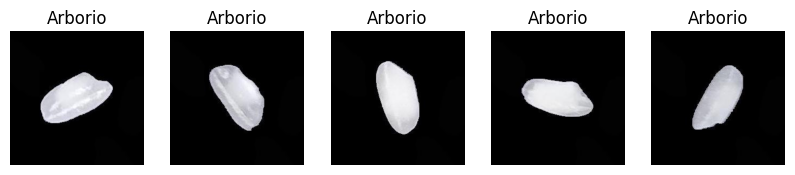

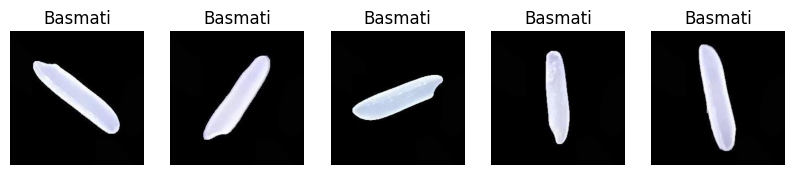

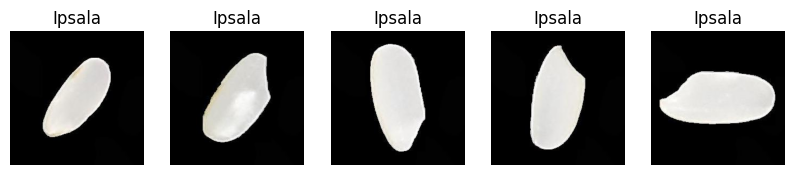

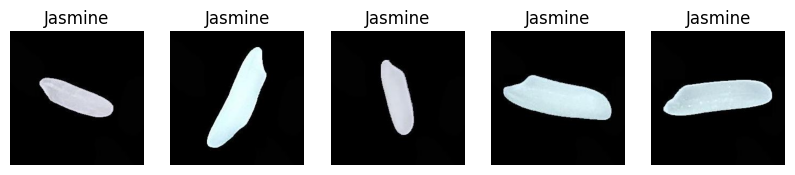

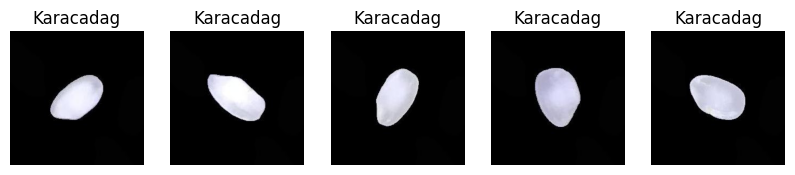

In [6]:
# Display a few example images from each class
for label in df['label'].unique():
    plt.figure(figsize=(10, 10))
    sample_images = df[df['label'] == label].sample(5)
    for i, image_path in enumerate(sample_images['image']):
        img = Image.open(image_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()


## Vorverarbeitung der Daten

### Erkennen von Anomalien und Ausreißern

In [7]:
# Example code to check for corrupted images
for image_path in df['image']:
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is, in fact, an image
    except (IOError, SyntaxError) as e:
        print(f"Bad file: {image_path}")



### Testen von Annahmen, Auswahl und Entwicklung von Merkmalen, Optimierung des Modellentwurfs, Erleichterung der Datenbereinigung, Verbesserung der Kommunikation

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [9]:
# # Split the data into training and test sets
# train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


In [10]:
# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f'Train set: {train_df.shape}')
print(f'Validation set: {val_df.shape}')
print(f'Test set: {test_df.shape}')

Train set: (52500, 3)
Validation set: (11250, 3)
Test set: (11250, 3)


# Datenaufteilung und Modelltraining

In [11]:
# # Data augmentation
# datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2,
#     rotation_range=10, 
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True
# )

# # Create training and validation generators
# train_generator = datagen.flow_from_dataframe(
#     train_df,
#     x_col='image',
#     y_col='label',
#     target_size=(64, 64), 
#     batch_size=32,
#     class_mode='categorical',
#     subset='training'
# )

# validation_generator = datagen.flow_from_dataframe(
#     train_df,
#     x_col='image',
#     y_col='label',
#     target_size=(64, 64), 
#     batch_size=32,
#     class_mode='categorical',
#     subset='validation'
# )

# # Define the CNN model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(len(train_df['label'].unique()), activation='softmax')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // validation_generator.batch_size,
#     epochs=10,
#     verbose=1
# )

In [34]:
def preprocess_image(image_path, size=(128, 128)):
    img = Image.open(image_path)
    img = img.resize(size)
    img = np.array(img) / 255.0
    return img

In [12]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, size=(128, 128), shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.size = size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_df)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, batch_df):
        X = np.empty((self.batch_size, *self.size, 3))
        y = np.empty((self.batch_size), dtype=int)
        for i, (image_path, label) in enumerate(zip(batch_df['image'], batch_df['label_encoded'])):
            X[i,] = preprocess_image(image_path, self.size)
            y[i] = label
        y = tf.keras.utils.to_categorical(y, num_classes=len(label_encoder.classes_))
        return X, y

# Create data generators
train_generator = DataGenerator(train_df, batch_size=32)
val_generator = DataGenerator(val_df, batch_size=32)
test_generator = DataGenerator(test_df, batch_size=32)

# Example of using the generators with a simple model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generators
history = model.fit(train_generator, validation_data=val_generator, epochs=10)

c:\Users\vae.tiolamon\Documents\DHBW 4. Semester\Machine Learning Fundamentals\MLsem4\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\vae.tiolamon\Documents\DHBW 4. Semester\Machine Learning Fundamentals\MLsem4\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1640/1640 ━━━━━━━━━━━━━━━━━━━━ 415s 252ms/step - accuracy: 0.9374 - loss: 0.1827 - val_accuracy: 0.9879 - val_loss: 0.0395
Epoch 2/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 372s 226ms/step - accuracy: 0.9856 - loss: 0.0418 - val_accuracy: 0.9793 - val_loss: 0.0664
Epoch 3/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 370s 226ms/step - accuracy: 0.9887 - loss: 0.0348 - val_accuracy: 0.9830 - val_loss: 0.0601
Epoch 4/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 407s 248ms/step - accuracy: 0.9899 - loss: 0.0277 - val_accuracy: 0.9818 - val_loss: 0.0587
Epoch 5/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 421s 256ms/step - accuracy: 0.9931 - loss: 0.0199 - val_accuracy: 0.9890 - val_loss: 0.0377
Epoch 6/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 417s 254ms/step - accuracy: 0.9942 - loss: 0.0172 - val_accuracy: 0.9882 - val_loss: 0.0415
Epoch 7/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 367s 224ms/step - accuracy: 0.9951 - loss: 0.0142 - val_accuracy: 0.9897 - val_loss: 0.0519
Epoch 8/10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 365s 222ms/step - accuracy: 0.9

# Modellbewertung

In [13]:
# # Evaluate the model on the test data
# test_generator = datagen.flow_from_dataframe(
#     test_df,
#     x_col='image',
#     y_col='label',
#     target_size=(64, 64),  # Consistent image size
#     batch_size=32,
#     class_mode='categorical'
# )

# Evaluate the model
loss, cnn_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {cnn_accuracy}")



351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.9906 - loss: 0.0570
Test Accuracy: 0.9897614121437073


# Modellvergleich

### Entscheidungsbaum-Modell

In [17]:
def load_and_flatten_image(image_path):
    img = Image.open(image_path).resize((128, 128))  # Consistent size
    img_array = np.array(img).flatten()
    return img_array

# Load and flatten images
train_images = np.array([load_and_flatten_image(img_path) for img_path in train_df['image']])
test_images = np.array([load_and_flatten_image(img_path) for img_path in test_df['image']])

# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_df['label'])
test_labels = le.transform(test_df['label'])

# Train Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(train_images, train_labels)

# Predict and evaluate
dt_predictions = dt_model.predict(test_images)
dt_accuracy = accuracy_score(test_labels, dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy}")

Decision Tree Accuracy: 0.9336888888888889


### Vergleich der Modelle

In [18]:
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"CNN Accuracy: {cnn_accuracy}")

Decision Tree Accuracy: 0.9336888888888889
CNN Accuracy: 0.9897614121437073


# Implementierung und Einsatz

In [24]:
# Speichern des Modells
model.save('rice_cnn_model.h5')



In [25]:
# Laden des Modells für den Einsatz
loaded_model = load_model('rice_cnn_model.h5')

In [37]:
def predict_image(image_path):
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
    prediction = loaded_model.predict(img)
    return np.argmax(prediction)

# Beispielvorhersage
sample_image_path = 'Ipsala.jpg' 

predicted_class = predict_image(sample_image_path)
print(f'Predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class: 2
